In [35]:
%pip install numpy
%pip install keras
%pip install matplotlib
%pip install tensorflow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 294.9/294.9 kB 4.6 MB/s eta 0:00:00



In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [37]:
df = pd.read_csv("./wildfire_dataset.csv")

FSA_dict = {'C': [0, {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}], 
            'E': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}], 
            'H': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}], 
            'G': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}], 
            'L': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}], 
            'M': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}], 
            'P': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}], 
            'R': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}], 
            'S': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}] , 
            'W': [0, {'A': 0, 'B': 0, 'C' : 0, 'D': 0, 'E': 0}]}


for index in df.index: 
    temp = df.loc[index, 'fire_number']
    temp = temp[:1]
    FSA_dict[temp][0] +=1
    classtemp = df.loc[index, 'size_class']
    FSA_dict[temp][1][classtemp] += 1

print(FSA_dict)

{'C': [4017, {'A': 3763, 'B': 209, 'C': 40, 'D': 3, 'E': 2}], 'E': [1901, {'A': 1423, 'B': 404, 'C': 48, 'D': 14, 'E': 12}], 'H': [3362, {'A': 1460, 'B': 1365, 'C': 313, 'D': 110, 'E': 114}], 'G': [1486, {'A': 1038, 'B': 379, 'C': 59, 'D': 6, 'E': 4}], 'L': [2663, {'A': 1678, 'B': 815, 'C': 111, 'D': 38, 'E': 21}], 'M': [1719, {'A': 869, 'B': 573, 'C': 138, 'D': 48, 'E': 91}], 'P': [1975, {'A': 1345, 'B': 482, 'C': 104, 'D': 24, 'E': 20}], 'R': [1657, {'A': 1243, 'B': 342, 'C': 50, 'D': 11, 'E': 11}], 'S': [3039, {'A': 1813, 'B': 981, 'C': 157, 'D': 44, 'E': 44}], 'W': [1095, {'A': 770, 'B': 275, 'C': 40, 'D': 4, 'E': 6}]}


In [57]:
weights = {'A': 0.1, 'B': 4.0, 'C': 20.0, 'D': 200.0, 'E': 1961.53}
weighted_FSA = {'C': 0, 'E': 0, 'H': 0, 'G': 0, 'L': 0, 'M': 0, 'P': 0, 'R': 0, 'S': 0, 'W': 0}

for key, value in FSA_dict.items():
    for k, w in weights.items():
        weighted_FSA[key] += value[1][k]*weights[k]

print(weighted_FSA)    


{'C': 6535.360000000001, 'E': 29056.66, 'H': 257480.41999999998, 'G': 11845.92, 'L': 54439.92999999999, 'M': 193238.13, 'P': 48173.1, 'R': 26269.129999999997, 'S': 102352.62, 'W': 14546.18}


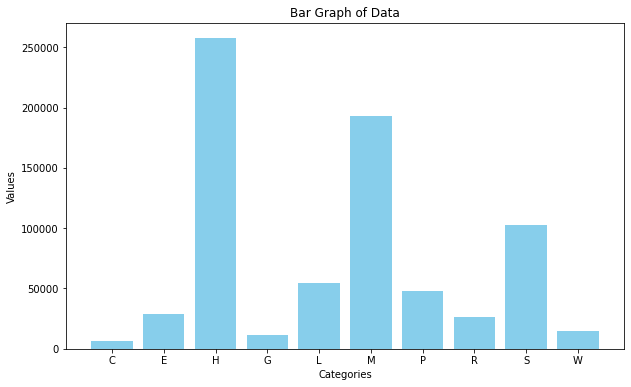

In [58]:
categories = list(weighted_FSA.keys())
values = list(weighted_FSA.values())

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')
plt.title('Bar Graph of Data')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.show()

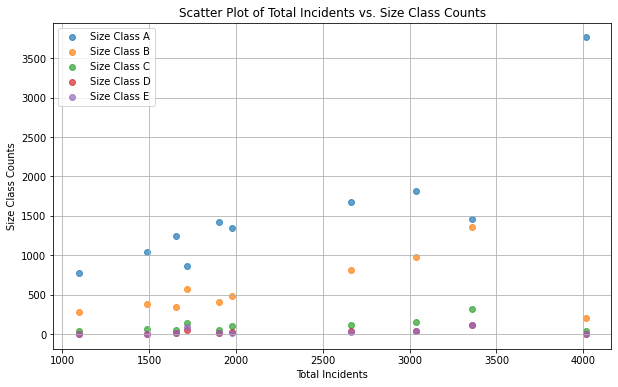

In [52]:
fsa_codes = list(FSA_dict.keys())
total_incidents = [data[0] for data in FSA_dict.values()]
size_class_counts = {cls: [data[1][cls] for data in FSA_dict.values()] for cls in ['A', 'B', 'C', 'D', 'E']}

plt.figure(figsize=(10, 6))
for cls, counts in size_class_counts.items():
    plt.scatter(total_incidents, counts, label=f'Size Class {cls}', alpha=0.7)

plt.title('Scatter Plot of Total Incidents vs. Size Class Counts')
plt.xlabel('Total Incidents')
plt.ylabel('Size Class Counts')
plt.legend()
plt.grid(True)
plt.show()

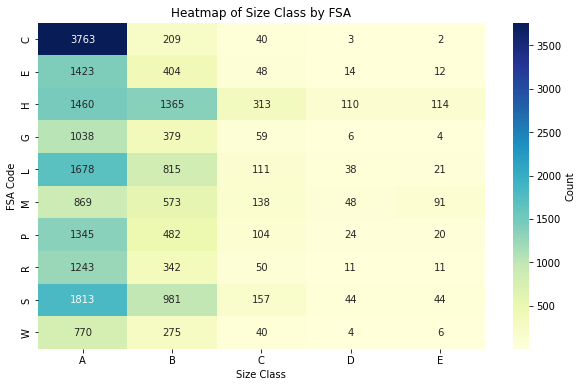

In [49]:
df = pd.DataFrame(FSA_dict).T
df.columns = ['Total', 'Size Class Count']

# Extracting Size Class information
size_class = df.columns

df = df['Size Class Count'].apply(pd.Series)

# Count of Size Classes
count_size_classes = len(df.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('Heatmap of Size Class by FSA')
plt.xlabel('Size Class')
plt.ylabel('FSA Code')
plt.show()



<Figure size 720x432 with 0 Axes>

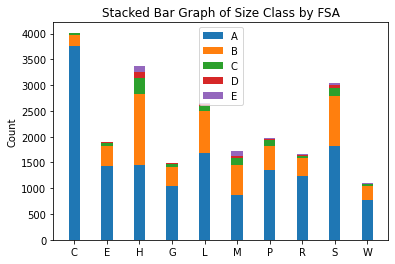

In [51]:
labels = list(FSA_dict.keys())
classes = list(FSA_dict[labels[0]][1].keys())
data = [[FSA_dict[fsa][1][cls] for fsa in labels] for cls in classes]

fig, ax = plt.subplots()
width = 0.35
ind = np.arange(len(labels))
bottom = np.zeros(len(labels))
for i, cls in enumerate(classes):
    ax.bar(ind, data[i], width, bottom=bottom, label=cls)
    bottom += np.array(data[i])

ax.set_ylabel('Count')
ax.set_title('Stacked Bar Graph of Size Class by FSA')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()
plt.show()